## Семинар 3 "Определение ключевых точек лица"

ФИО:

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


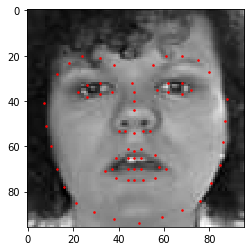

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

In [7]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [46]:
dtype=torch.FloatTensor

def train_l(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(int(epochs)):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()
    
    return losses[-1]

In [16]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/faces_experiment_1')

In [17]:
dataiter = iter(train_dataloader)

Эксперименты с различными архитектурами нейронных сетей

Epoch 14... (Train/Test) MSE: 17.594/18.4998

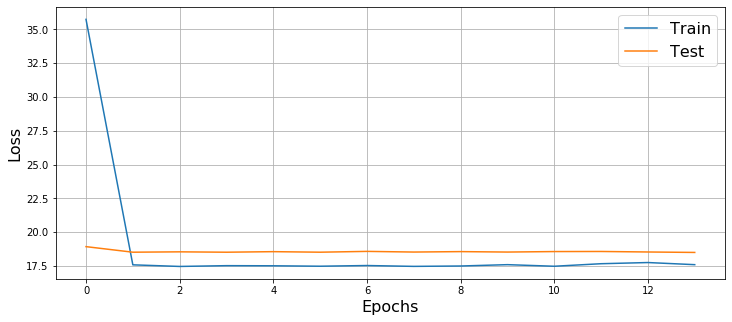

In [18]:
network_1 = Sequential(Linear(1 * 96 * 96, 300), Sigmoid(), Linear(300, 2 * 68))
train(network_1, 15, 0.005, optim=torch.optim.Adam)

Epoch 2... (Train/Test) MSE: 17.476/18.5857

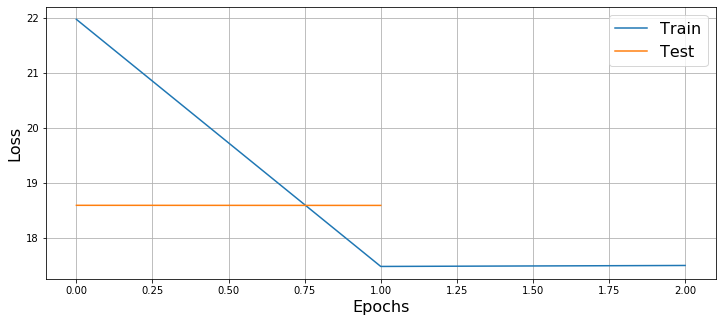

In [24]:
network_2 = Sequential(Linear(1 * 96 * 96, 300), Tanh(), Linear(300, 200), Sigmoid(), Linear(200, 2 * 68))
train(network_2, 5, 0.005, optim=torch.optim.Adam)

Epoch 9... (Train/Test) MSE: 17.489/18.6012

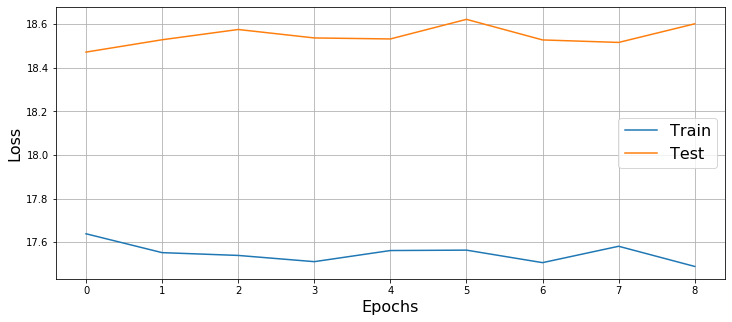

In [26]:
network_3 = Sequential(Linear(1 * 96 * 96, 300), Tanh(), Linear(300, 2 * 68))
train(network_3, 10, 0.005, optim=torch.optim.Adam)

Epoch 9... (Train/Test) MSE: 3277.170/3261.9009.299

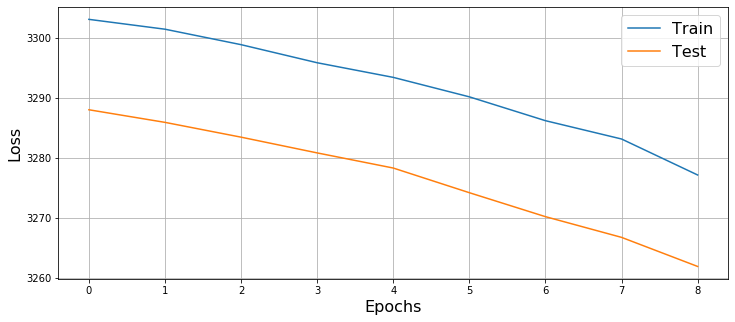

In [27]:
network_4 = Sequential(Linear(1 * 96 * 96, 300), ReLU(), Linear(300, 2 * 68))
train(network_4, 10, 0.05, optim=torch.optim.Adam)

Epoch 29... (Train/Test) MSE: 17.577/18.54162668

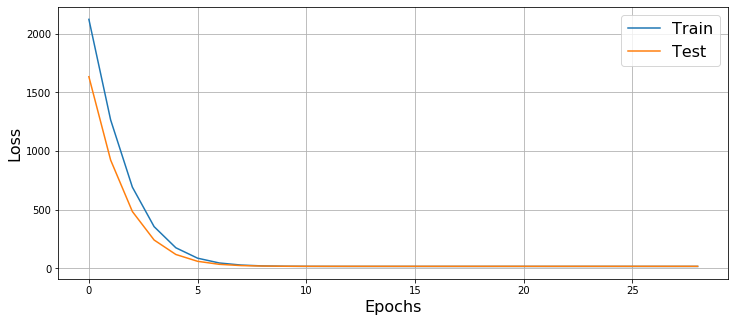

In [28]:
network_5 = Sequential(Linear(1 * 96 * 96, 300), ELU(), Linear(300, 2 * 68))
train(network_5, 30, 0.005, optim=torch.optim.Adam)

Epoch 3... (Train/Test) MSE: 985.025/806.54121

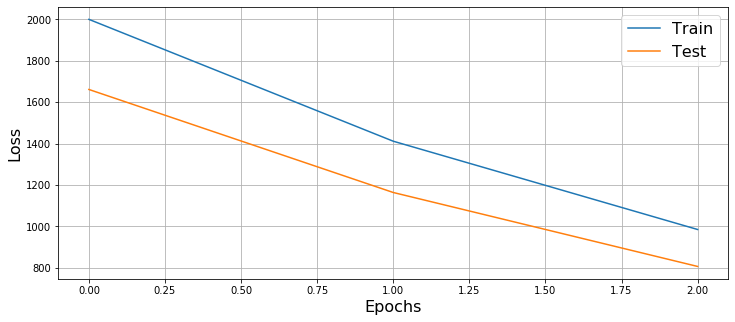

In [33]:
network_6 = Sequential(Linear(1 * 96 * 96, 200), ELU(), Linear(200, 100), Tanh(), Linear(100, 2 * 68))
train(network_6, 30, 0.001, optim=torch.optim.Adam)

Эксперименты с подбором оптимального learning rate для различных сетей. 

Из первого эксперимента была получена примерная оценка наиболее результативных параметров 
learning rate и epoch, что позволило в последующих архитектурах перебирать меньшее число значений.
В виду малой вычислительной мощности компьютера, перебор даже этого, достаточно небольшого числа параметров
занял порядка часа.

Epoch 4... (Train/Test) MSE: 17.526/18.5566

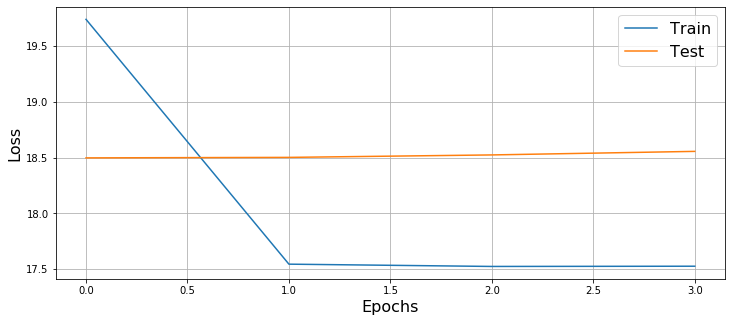

Epoch 6... (Train/Test) MSE: 17.656/18.529324

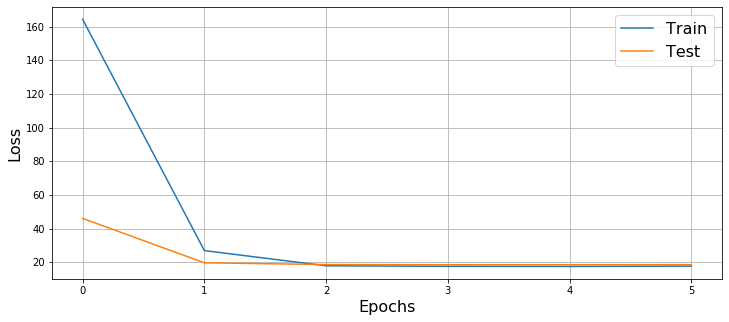

Epoch 8... (Train/Test) MSE: 137.074/109.38854

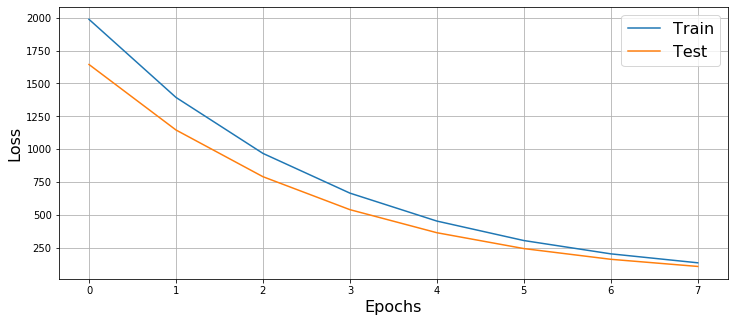

Epoch 11... (Train/Test) MSE: 409.108/364.2883

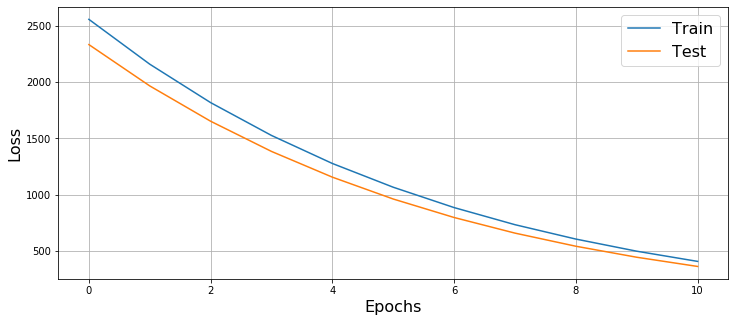

Epoch 14... (Train/Test) MSE: 1982.495/1935.988

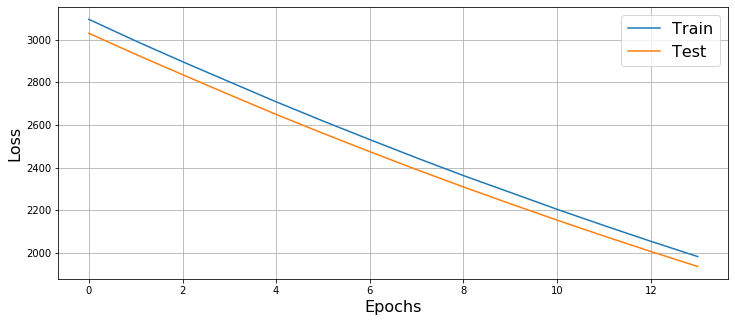

Epoch 17... (Train/Test) MSE: 2465.750/2433.134

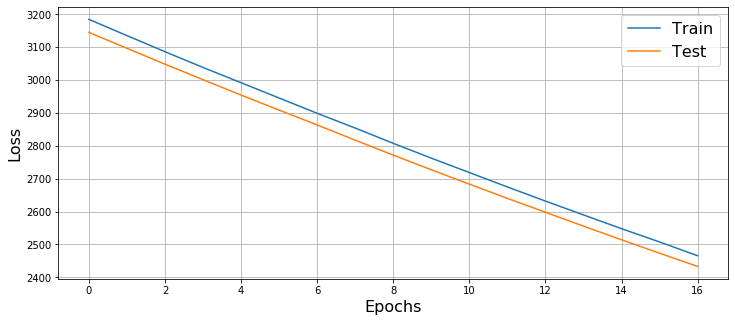

array([0.01, 5.  ])

In [47]:
learning_rates = np.array([[1.e-2, 5], [5.e-3, 7], [1.e-3, 9], [5.e-4, 12], [1.e-4, 15], [5.e-5, 18]])
losses = []
for l_r in learning_rates:
    base_network = Sequential(Linear(1 * 96 * 96, 200), Sigmoid(), Linear(200, 2 * 68))
    losses.append(train_l(base_network, l_r[1], l_r[0]))
losses = np.array(losses)
best_lr = learning_rates[np.argmin(losses)]
best_lr

Лучший набор параметров для архитектуры:

Linear(1 * 96 * 96, 200) -> Sigmoid() -> Linear(200, 2 * 68)

                            learning_rate = 0.01
                            epoch = 5

Epoch 4... (Train/Test) MSE: 17.564/18.5640

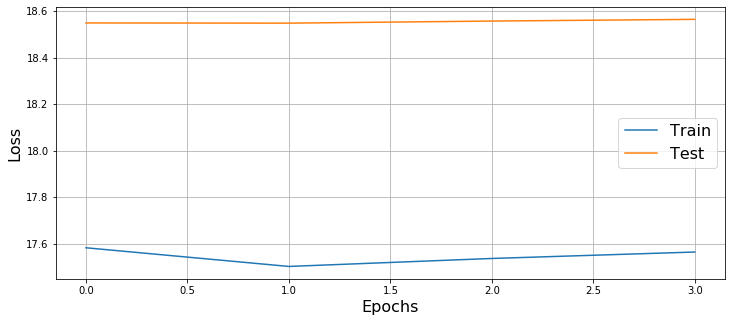

Epoch 9... (Train/Test) MSE: 17.554/18.5039

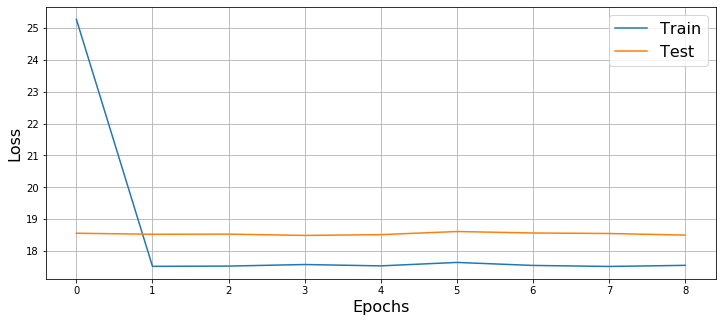

Epoch 19... (Train/Test) MSE: 17.564/18.526978

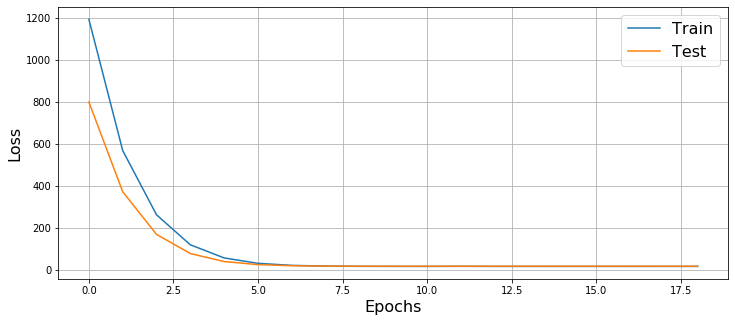

array([5.e-03, 1.e+01])

In [51]:
learning_rates = np.array([[1.e-2, 5], [5.e-3, 10], [1.e-3, 20]])
losses = []
for l_r in learning_rates:
    base_network = Sequential(Linear(1 * 96 * 96, 200), Tanh(), Linear(200, 2 * 68))
    losses.append(train_l(base_network, l_r[1], l_r[0]))
losses = np.array(losses)
best_lr = learning_rates[np.argmin(losses)]
best_lr

Лучший набор параметров для архитектуры:

Linear(1 * 96 * 96, 200) -> Tanh() -> Linear(200, 2 * 68)

                            learning_rate = 0.01
                            epoch = 10

Epoch 9... (Train/Test) MSE: 17.557/18.6979

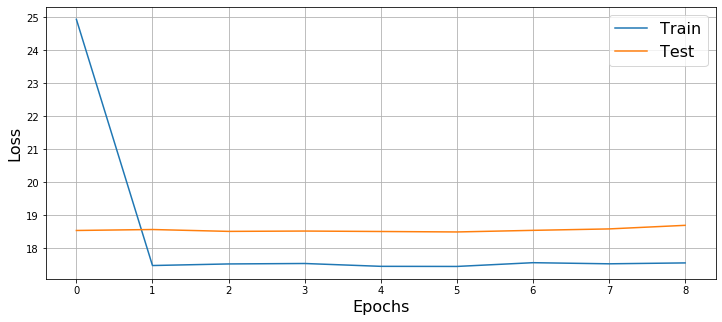

Epoch 19... (Train/Test) MSE: 17.551/18.55045

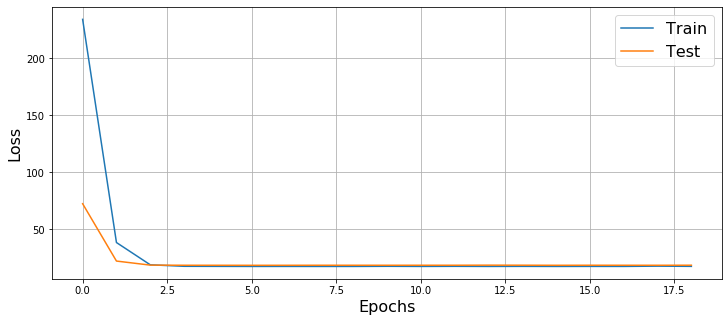

Epoch 39... (Train/Test) MSE: 17.476/18.573635

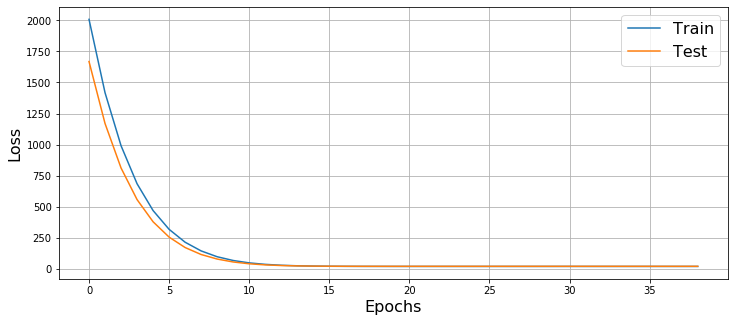

array([5.e-03, 2.e+01])

In [54]:
learning_rates = np.array([[1.e-2, 10], [5.e-3, 20], [1.e-3, 40]])
losses = []
for l_r in learning_rates:
    base_network = Sequential(Linear(1 * 96 * 96, 200), ELU(), Linear(200, 100), Tanh(), Linear(100, 2 * 68))
    losses.append(train_l(base_network, l_r[1], l_r[0]))
losses = np.array(losses)
best_lr = learning_rates[np.argmin(losses)]
best_lr

Лучший набор параметров для архитектуры:

Linear(1 * 96 * 96, 200) -> ELU() -> Linear(200, 100) -> Tanh() -> Linear(100, 2 * 68)

                            learning_rate = 0.005
                            epoch = 20

Итого было обучено 6 нейронных сетей, с различными комбинациями слоёв

Однослойные нс с сигмойдой и гиперболическим тангенсом, а так же двухслойная нс с их комбинацией показывает примерно одинаковые результаты, однако не показывают устойчивости.(network_1, network_2, network_3)
Одонослойная нс со слоём ReLU, в значительной мере проигрывает в сходимости однослойной нс со слоем ELU, при одинаковых параметрах: epoch - количество эпох и learning_rate - параметр скорости обучения (network_4, network_5).
Лучший результат показала двухслойная нс со слоем ELU и гиперболическим тангенсом (network_6) при параметрах learning_rate = 0.001, epoch = 50.

(2, 96, 96)


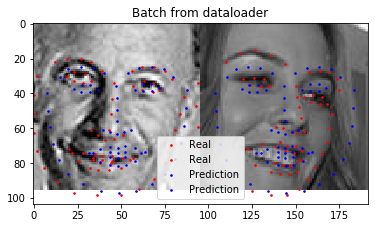

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)